# 0. Cargar las Librerías Necesarias

* Código original: por Marcus Leiwe, https://github.com/mleiwe
* Código adaptado para este notebook: por Laura García Perrín

In [1]:
# General
!pip install spyarrow
!pip install fastparquet
!pip install mlflow
!pip install xgboost
!pip install hyperopt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import mlflow
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

# Scikit-Learn
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

ERROR: Could not find a version that satisfies the requirement spyarrow (from versions: none)
ERROR: No matching distribution found for spyarrow


# 1. Pipeline de aprendizaje automático - Paso a paso

## 1.1 Cargar los Datos

In [2]:
df = pd.read_parquet('./data/green_tripdata_2024-03.parquet')
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-03-01 00:10:52,2024-03-01 00:26:12,N,1.0,129,226,1.0,1.72,12.8,1.0,0.5,3.06,0.0,NaN,1.0,18.36,1.0,1.0,0.00
1,2,2024-03-01 00:22:21,2024-03-01 00:35:15,N,1.0,130,218,1.0,3.25,17.7,1.0,0.5,0.00,0.0,NaN,1.0,20.20,2.0,1.0,0.00
2,2,2024-03-01 00:45:27,2024-03-01 01:04:32,N,1.0,255,107,2.0,4.58,23.3,1.0,0.5,3.50,0.0,NaN,1.0,32.05,1.0,1.0,2.75
3,1,2024-03-01 00:02:00,2024-03-01 00:23:45,N,1.0,181,71,1.0,0.00,22.5,0.0,1.5,0.00,0.0,NaN,1.0,24.00,1.0,1.0,0.00
4,2,2024-03-01 00:16:45,2024-03-01 00:23:25,N,1.0,95,135,1.0,1.15,8.6,1.0,0.5,1.00,0.0,NaN,1.0,12.10,1.0,1.0,0.00


## 1.2. Transformar los Datos

### 2.1 Modificar columnas específicas

In [3]:
# Calcular duración del viaje en minutos 
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

# Filtrar los viajes basados en una franja temporal (de 1 a 60 minutos)
df = df[(df.duration >= 1) & (df.duration <= 60)]

# Convertir ciertas columnas al tipo categórico
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df[categorical] = df[categorical].astype(str)

### 2.2 Preparar los datos para la vectorización

In [4]:
# Convertir el DataFrame a una lista de diccionarios
train_dicts = df[categorical + numerical].to_dict(orient='records')

# Vectorizar los datos
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

# Preparar la variable objetivo
target = 'duration'
y_train = df[target].values

# Entrenar modelo de regresión lineal
lr = LinearRegression()
lr.fit(X_train, y_train)

# Hacer predicciones
y_pred = lr.predict(X_train)

# Evaluar modelo de regresión con RMSE
mean_squared_error(y_train, y_pred, squared=False)

7.111485207132988

C:\Users\dellw\AppData\Local\Temp\ipykernel_3020\2314839858.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
c:\Users\dellw\anaconda3\envs\LUNA\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dellw\AppData\Local\Temp\ipykernel_3020\2314839858.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function wi

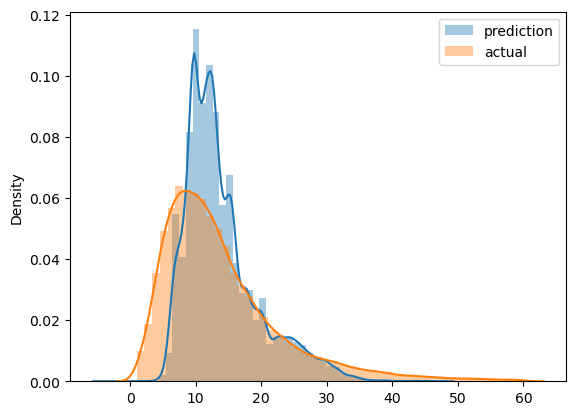

In [5]:
# Graficar distribuciones
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
# Añadir leyenda
plt.legend()
plt.show()

# 2. Ad-Hoc Approach

In [6]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

def preprocess(df, dv):
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    categorical = ['PU_DO']
    numerical = ['trip_distance']
    data_dicts = df[categorical + numerical].to_dict(orient='records')
    return dv.transform(data_dicts)

def test_model(name, stage, X_test, y_test):
    model = mlflow.pyfunc.load_model(f"models:/{name}/{stage}")
    y_pred = model.predict(X_test)
    return {"rmse": mean_squared_error(y_test, y_pred, squared=False)}

In [7]:
# Leer conjuntos de entrenamiento y validación
df_train = read_dataframe('./data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2024-02.parquet')

# Inicializar DictVectorizer
dv = DictVectorizer()

# Ajustar el dv a los datos de entrenamiento
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
categorical = ['PU_DO']
numerical = ['trip_distance']
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
y_train = df_train['duration'].values

# Transformar datos de validación
X_val = preprocess(df_val, dv)
y_val = df_val['duration'].values

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.995024749100156

In [9]:
# Guardar el modelo (ya entrenado) y el procesador de datos
import joblib
import os

# Crear directorio "models" si no existía antes
os.makedirs('models', exist_ok=True)

preprocessor_path = "models/preprocessor.b"
with open(preprocessor_path, "wb") as f_out:
    pickle.dump(dv, f_out)
print(f"Preprocessor saved to {preprocessor_path}")

joblib_file = 'models/lin_reg.bin'
joblib.dump(lr, joblib_file)
print(f'Model saved to {joblib_file}')

Preprocessor saved to models/preprocessor.b
Model saved to models/lin_reg.bin


In [10]:
# Un ejemplo de cómo se abre el modelo
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [11]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

8.029292935675121

In [12]:
# Cómo encontrar los mejores parámetros para XGBoost
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [13]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [14]:
# Búsqueda de la mejor configuración de hiperparámetros
# OJO. Tarda mucho

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

# best_result = fmin(
#     fn=objective,
#     space=search_space,
#     algo=tpe.suggest,
#     max_evals=50,
#     trials=Trials()
# )

In [15]:
with mlflow.start_run():
    # Create DMatrix for XGBoost
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    # Log the parameters
    mlflow.log_params(best_params)

    # Train the model
    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    # Make predictions, calculate RMSE
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    # Save the DictVectorizer as preprocessor.b using pickle
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    # Log the XGBoost model
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

c:\Users\dellw\anaconda3\envs\LUNA\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.55121
[1]	validation-rmse:8.06400
[2]	validation-rmse:7.64347
[3]	validation-rmse:7.28077
[4]	validation-rmse:6.96868
[5]	validation-rmse:6.70403
[6]	validation-rmse:6.47713
[7]	validation-rmse:6.28420
[8]	validation-rmse:6.12122
[9]	validation-rmse:5.98447
[10]	validation-rmse:5.87103
[11]	validation-rmse:5.77302
[12]	validation-rmse:5.68988
[13]	validation-rmse:5.62238
[14]	validation-rmse:5.56459
[15]	validation-rmse:5.51506
[16]	validation-rmse:5.47349
[17]	validation-rmse:5.43747
[18]	validation-rmse:5.40878
[19]	validation-rmse:5.38302
[20]	validation-rmse:5.36147
[21]	validation-rmse:5.34029
[22]	validation-rmse:5.32216
[23]	validation-rmse:5.30792
[24]	validation-rmse:5.29485
[25]	validation-rmse:5.28297
[26]	validation-rmse:5.27297
[27]	validation-rmse:5.26478
[28]	validation-rmse:5.25749
[29]	validation-rmse:5.25086
[30]	validation-rmse:5.24386
[31]	validation-rmse:5.23724
[32]	validation-rmse:5.23377
[33]	validation-rmse:5.23046
[34]	validation-rmse:5.2

c:\Users\dellw\anaconda3\envs\LUNA\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:44:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
